# Имитационное обучение

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow version : 1.12.0
Gym version : 0.10.5


Using TensorFlow backend.


## Собираем статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [2]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

#Функция для генерации стратегии
def generate_rollouts(num_rollouts,max_steps,render=False):
    
    #Инициализация tensoflow сессии
    with tf.Session():
        tf_util.initialize()

        # Определение массивов
        returns = []
        observations = []
        actions = []

        #Цикл сбора данных 
        for i in range(num_rollouts):
            
            #Параметры до начальных значений
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            #Цикл выполняется до конца эпизода
            while not done:
                #Выбрать действие в зависимости от наблюдения
                action = policy_fn(obs[None,:])
                #Добавить образец в массивы
                observations.append(obs)
                actions.append(action)
                #Применить действие к окружающей среде
                obs, r, done, _ = env.step(action)
                #Рассчитать общее вознаграждение
                totalr += r
                steps += 1
                #Обновить среду
                if render==True:
                    env.render()
                if steps >= max_steps:
                    break
            #Добавить общее вознаграждение
            returns.append(totalr)

        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

In [3]:
generate_rollouts(num_rollouts=4,max_steps=100,render=True);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw
mean return 639.5091842358678
std of return 3.68423231570653


## Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью когорого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

In [3]:
from sklearn.utils import shuffle

class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64):
        
        #Определить tensorflow сессию
        self.sess = tf.Session()
        #Входные и выходные данные
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        #Функция потерь l2_loss
        self.loss = self.l2(self.output_placeholder_model, self.output_placeholder_expert)
    
    def l2(self, x, y):
        return np.sum((x-y)**2)

    def build_model(self, input_placeholder):
        model = Sequential()
        model.add(Dense(256, activation='relu', input_shape=tuple((self.input_shape[-1],))))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.output_data.shape[-1], activation='linear'))
        return model(input_placeholder)

    def train(self, epochs = 20, train_data = None, test_data = None):
        if train_data is None and test_data is None :
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        #Использование Adam-оптимизации
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        saver = tf.train.Saver()
        batch_idxs = len(train_data) // self.batch_size
        writer = tf.summary.FileWriter("exp")
        
        #Добавление графа
        writer.add_graph(self.sess.graph)

        #Инициализировать переменные нейронной сети
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        for epoch in range(epochs):
            for idx in range(batch_idxs):
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Обучение модели на экспертных данных

In [5]:
#Генерация экспертных данных
data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']
print ('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

#Перемешать данные
x,y = shuffle(x,y)

#Создать объект класса BC_Model и обучить его
cloner=BC_Model(x,y)
cloner.train()

mean return 642.6444943685649
std of return 7.53860367371028
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)


### Испытание модели

In [6]:
num_eval_rollouts=20
returns=[]
for i in range(num_eval_rollouts):
    totalr=0
    done=False
    obs=env.reset()
    while not done:
        action=cloner.sample(obs)
        obs,r,done,_=env.step(action)
        env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

mean return 326.7962488742931
std of return 80.28861343519509


loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 227.75584479518176
std of return 0.504133616016094
Creating window glfw
mean return 261.97433812158505
std of return 9.488507787350443
mean return 227.78325448043483
std of return 0.5263067986090697
mean return 367.9958955963668
std of return 4.563288191704574
mean return 227.91925296592726
std of return 0.5548439664310881
mean return 330.971616613419
std of return 37.87455515421677
mean return 228.00867956076007
std of return 0.5033848802910548
mean return 450.36774905417025
std of return 28.206122346369764
mean return 227.92777872764705
std of return 0.5247574875413059
mean return 395.2457847357145
std of return 3.598154241511892


Text(0.5, 1.0, 'Зависисмость отдачи от количества набранной статистики в окружении Hopper-v2')

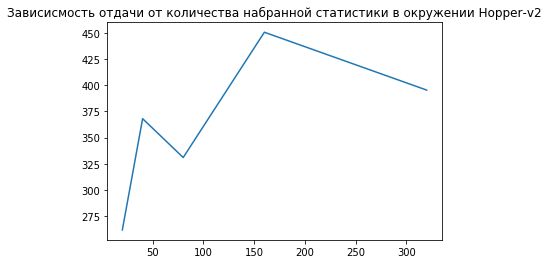

In [7]:
#Модель №1. Окружение "Hopper-v2"

#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

#Инициализация списков для последующего построения графика
list_of_totalr = list()
list_of_num_rollouts = [20, 40, 80, 160, 320]

#Обучение модели на экспертных данных в цикле 
for num in list_of_num_rollouts:
    
    data=generate_rollouts(num_rollouts=num,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']
    
    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train()
    
    #Испытываю модель         
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

plt.plot(list_of_num_rollouts, list_of_totalr)
plt.title('Зависисмость отдачи от количества набранной статистики в окружении Hopper-v2')

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return -3.8775434163353624
std of return 1.7169441805879633
Creating window glfw
mean return -6.746476624592132
std of return 1.8831939972710143
mean return -3.9601151431549027
std of return 1.8633175109405182
mean return -5.510407577035061
std of return 2.620085845885988
mean return -3.857354079022227
std of return 1.8443191467950564
mean return -4.778464894575228
std of return 2.099324235965638
mean return -3.875874308281529
std of return 1.6750186763677157
mean return -4.706925699323689
std of return 1.5740346068810034
mean return -3.917128794429807
std of return 1.6951976947050893
mean return -4.625761662804409
std of return 2.2491670798133776


Text(0.5, 1.0, 'Зависисмость отдачи от количества набранной статистики в окружении Reacher-v2')

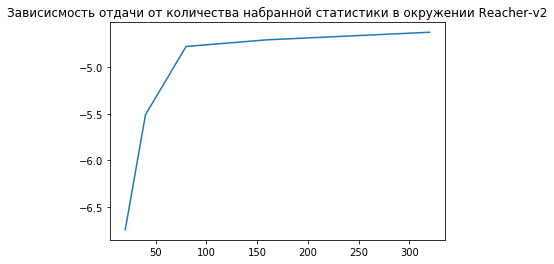

In [8]:
#Модель №2. Окружение "Reacher-v2"

#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

#Инициализация списков для последующего построения графика
list_of_totalr = list()
list_of_num_rollouts = [20, 40, 80, 160, 320]

#Обучение модели на экспертных данных в цикле 
for num in list_of_num_rollouts:
    
    data=generate_rollouts(num_rollouts=num,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train()
    
    #Испытываю модель         
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

plt.plot(list_of_num_rollouts, list_of_totalr)
plt.title('Зависисмость отдачи от количества набранной статистики в окружении Reacher-v2')

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 221.54915459472545
std of return 1.3244276203015404
Creating window glfw
mean return 431.201913234149
std of return 173.78540715517596
mean return 221.78446944110487
std of return 1.531028634493151
mean return 443.65941495321357
std of return 178.43074273526923
mean return 221.3745219036461
std of return 1.338778332273129
mean return 478.8860081594231
std of return 75.54128225382513
mean return 221.40469803358206
std of return 1.3136262934754985
mean return 458.24457817126665
std of return 97.5390341496016
mean return 221.3061048152233
std of return 1.403001251477303
mean return 427.7289446912572
std of return 29.489026164958503


Text(0.5, 1.0, 'Зависисмость отдачи от количества набранной статистики в окружении Walker2d-v2')

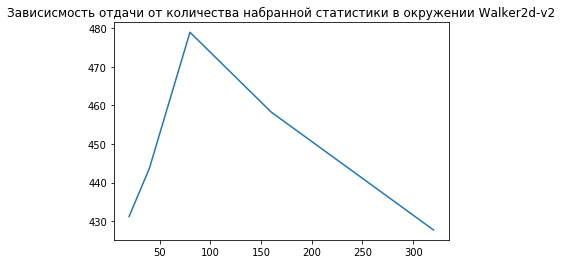

In [9]:
#Модель №3. Окружение "Walker2d-v2"

#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

#Инициализация списков для последующего построения графика
list_of_totalr = list()
list_of_num_rollouts = [20, 40, 80, 160, 320]

#Обучение модели на экспертных данных в цикле 
for num in list_of_num_rollouts:
    
    data=generate_rollouts(num_rollouts=num,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train()
    
    #Испытываю модель         
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

plt.plot(list_of_num_rollouts, list_of_totalr)
plt.title('Зависисмость отдачи от количества набранной статистики в окружении Walker2d-v2')

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 221.4511210753129
std of return 1.5249015295120518
Creating window glfw
mean return 250.59334860245386
std of return 163.12645863099897
mean return 221.8483593967713
std of return 1.2412615061614536
mean return 160.5934853083716
std of return 105.33922809828958
mean return 221.822946357608
std of return 1.312818346280113
mean return 559.2511888564874
std of return 57.16397566843682
mean return 221.54061741454763
std of return 1.4111708321001348
mean return 338.061574660657
std of return 23.951734742522067
mean return 221.40186216396404
std of return 1.4789316124140692
mean return 462.2248559884383
std of return 14.195283970378599


Text(0.5, 1.0, 'Зависисмость отдачи от количества эпох в окружении Walker2d-v2')

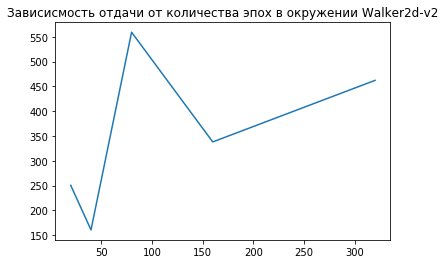

In [10]:
#Выбрана модель №3, строю зависимость от количества эпох

#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

#Инициализация списков для последующего построения графика
list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

#Обучение модели на экспертных данных в цикле 
for epoch in list_of_epochs:
    
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    #Испытываю модель         
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

plt.plot(list_of_epochs, list_of_totalr)
plt.title('Зависисмость отдачи от количества эпох в окружении Walker2d-v2')

## DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

In [11]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']

x,y = shuffle(x,y)

cloner=BC_Model(x,y)
cloner.train(epochs=10)

with tf.Session():
    DAgger_iter=30
    render=False
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=10)

obs (1, 376) (1, 376)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 641.0063478393429
std of return 12.393762720752813


### Проверяем работу

In [12]:
num_eval_rollouts=20
returns=[]
for i in range(num_eval_rollouts):
    totalr=0
    done=False
    obs=env.reset()
    while not done:
        action=cloner.sample(obs)
        obs,r,done,_=env.step(action)
        env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

Creating window glfw
mean return 69.65578192600309
std of return 0.22776015378283881


In [5]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

#Инициализация списков для последующего построения графика
list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

for epoch in list_of_epochs:
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))

x1 = list_of_epochs
y1 = list_of_totalr

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 641.8496954990622
std of return 7.792251590886538
Creating window glfw
mean return 643.1603213540668
std of return 9.179535641618592
mean return 644.5983259365021
std of return 9.809548258598147
mean return 639.7570055208162
std of return 7.179244826784822
mean return 646.2378268388469
std of return 9.488007712513161


In [6]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

y2 = list()

with tf.Session():
    DAgger_iter=5
    render=False
    # DAgger loop
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=5)
        
        num_eval_rollouts=20
        returns=[]
        for i in range(num_eval_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
                env.render()
                totalr+=r
            returns.append(totalr)
        y2.append(np.mean(returns))

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Creating window glfw


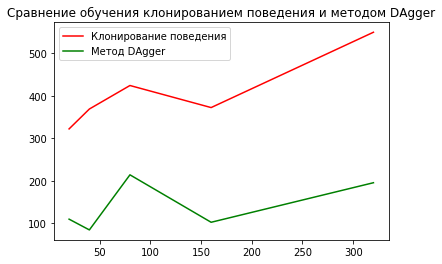

In [7]:
#Построение графиков сравнения
plt.plot(x1, y1, 'r', label='Клонирование поведения')
plt.plot(x1, y2, 'g', label='Метод DAgger')
plt.title('Сравнение обучения клонированием поведения и методом DAgger в окружении Humanoid-v2')
plt.legend()

In [8]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

for epoch in list_of_epochs:
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))

x1 = list_of_epochs
y1 = list_of_totalr

loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 420.44766445586595
std of return 22.31038179369784
Creating window glfw
mean return 416.070132243857
std of return 22.64226394875749
mean return 418.99484749545684
std of return 28.898627790425746
mean return 424.281372933411
std of return 26.34871419421813
mean return 411.9579129407804
std of return 33.411427580576756


In [9]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

y2 = list()

with tf.Session():
    DAgger_iter=5
    render=False
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=5)
        
        num_eval_rollouts=20
        returns=[]
        for i in range(num_eval_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
                env.render()
                totalr+=r
            returns.append(totalr)
        y2.append(np.mean(returns))

loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Creating window glfw


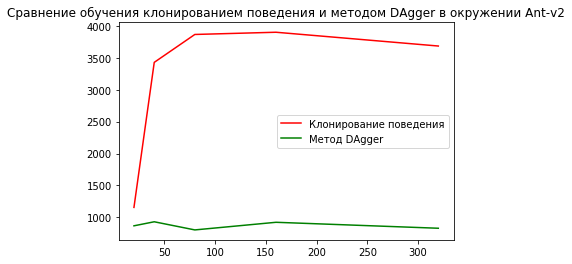

In [10]:
# построение графиков сравнения
plt.plot(x1, y1, 'r', label='Клонирование поведения')
plt.plot(x1, y2, 'g', label='Метод DAgger')
plt.title('Сравнение обучения клонированием поведения и методом DAgger в окружении Ant-v2')
plt.legend()

In [4]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

for epoch in list_of_epochs:
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))

x1 = list_of_epochs
y1 = list_of_totalr

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 281.5432360286359
std of return 25.130399206151157
Creating window glfw
mean return 286.03387077600416
std of return 32.76198451500585
mean return 273.08869947582946
std of return 24.06333848320649
mean return 293.46128283118503
std of return 25.577250199086016
mean return 283.1696110702058
std of return 26.66395695605106


In [5]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

y2 = list()

with tf.Session():
    DAgger_iter=5
    render=False
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=5)
        
        num_eval_rollouts=20
        returns=[]
        for i in range(num_eval_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
                env.render()
                totalr+=r
            returns.append(totalr)
        y2.append(np.mean(returns))

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Creating window glfw


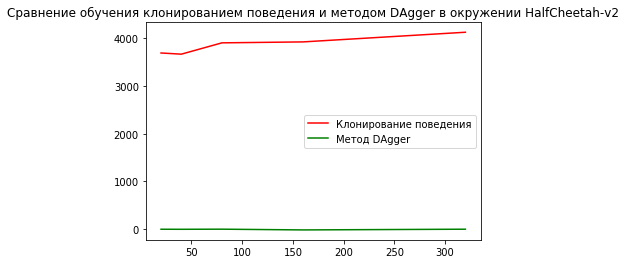

In [6]:
# построение графиков сравнения
plt.plot(x1, y1, 'r', label='Клонирование поведения')
plt.plot(x1, y2, 'g', label='Метод DAgger')
plt.title('Сравнение обучения клонированием поведения и методом DAgger в окружении HalfCheetah-v2')
plt.legend()

In [4]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)
list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

for epoch in list_of_epochs:
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))

x1 = list_of_epochs
y1 = list_of_totalr

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 228.09187696881764
std of return 0.442518220609388
Creating window glfw
mean return 227.9237708968912
std of return 0.42068226239409834
mean return 227.7860011965427
std of return 0.530242763964662
mean return 227.7587383368947
std of return 0.4593866163878783
mean return 227.62601996208315
std of return 0.43541743172939723


In [5]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

y2 = list()

with tf.Session():
    DAgger_iter=5
    render=False
    # DAgger loop
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=5)
        
        num_eval_rollouts=20
        returns=[]
        for i in range(num_eval_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
                env.render()
                totalr+=r
            returns.append(totalr)
        y2.append(np.mean(returns))

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Creating window glfw


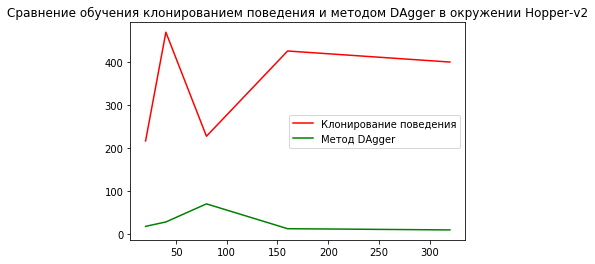

In [6]:
# построение графиков сравнения
plt.plot(x1, y1, 'r', label='Клонирование поведения')
plt.plot(x1, y2, 'g', label='Метод DAgger')
plt.title('Сравнение обучения клонированием поведения и методом DAgger в окружении Hopper-v2')
plt.legend()

In [7]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

for epoch in list_of_epochs:
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))

x1 = list_of_epochs
y1 = list_of_totalr

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return -3.94475264539748
std of return 1.797759514148451
Creating window glfw
mean return -3.9172068978979064
std of return 1.86186386251631
mean return -3.1342594212395776
std of return 1.5039214872879278
mean return -3.5027785728022613
std of return 1.906035710500871
mean return -4.019238202536219
std of return 1.9238721236313403


In [8]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
env_name="Reacher-v2"
#env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

y2 = list()

with tf.Session():
    DAgger_iter=5
    render=False
    # DAgger loop
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=5)
        
        num_eval_rollouts=20
        returns=[]
        for i in range(num_eval_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
                env.render()
                totalr+=r
            returns.append(totalr)
        y2.append(np.mean(returns))

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Creating window glfw


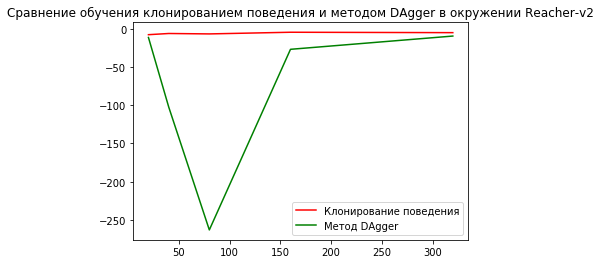

In [9]:
# построение графиков сравнения
plt.plot(x1, y1, 'r', label='Клонирование поведения')
plt.plot(x1, y2, 'g', label='Метод DAgger')
plt.title('Сравнение обучения клонированием поведения и методом DAgger в окружении Reacher-v2')
plt.legend()

In [10]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

list_of_totalr = list()
list_of_epochs = [20, 40, 80, 160, 320]

for epoch in list_of_epochs:
    data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
    x = data['observations']
    y = data['actions']

    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train(epochs=epoch)
    
    num_eval_rollouts=20
    returns=[]
    for i in range(num_eval_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            env.render()
            totalr+=r
        returns.append(totalr)
    list_of_totalr.append(np.mean(returns))

x1 = list_of_epochs
y1 = list_of_totalr

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
mean return 221.33267329828496
std of return 1.047502888728743
Creating window glfw
mean return 221.33944781454107
std of return 1.0174521468368696
mean return 221.43931928428796
std of return 1.5693104206740094
mean return 221.54872873398367
std of return 1.418736823297045
mean return 221.11815141126857
std of return 0.7224561534940388


In [11]:
#Выбираем среду (Выбранную среду необходимо раскомментировать)
#env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
env_name="Walker2d-v2"  

#Выберите файл стратегии эксперта из файла эксперта
expert_policy_file="experts/"+env_name+".pkl"

#Загрузка файла стратегии
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

#Создание среды
env = gym.make(env_name)

y2 = list()

with tf.Session():
    DAgger_iter=5
    render=False
    for i in range(DAgger_iter):
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        while not done:
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            new_obs.append(obs)
            new_actions.append(corrected_action)
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=np.array([x[-1]]), test_data = np.array([y[-1]]), epochs=5)
        
        num_eval_rollouts=20
        returns=[]
        for i in range(num_eval_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
                env.render()
                totalr+=r
            returns.append(totalr)
        y2.append(np.mean(returns))

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Creating window glfw


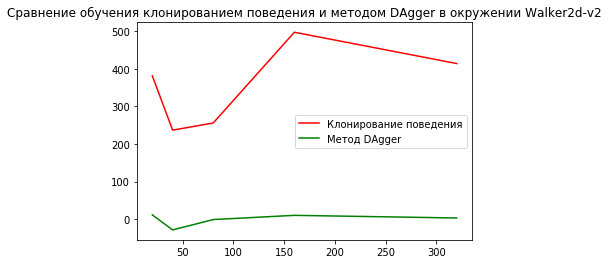

In [12]:
# построение графиков сравнения
plt.plot(x1, y1, 'r', label='Клонирование поведения')
plt.plot(x1, y2, 'g', label='Метод DAgger')
plt.title('Сравнение обучения клонированием поведения и методом DAgger в окружении Walker2d-v2')
plt.legend()

Для задачи Reacher-v2 видно, что с увеличением количества эпох метод DAgger будет работать лучше, чем клонирование поведения. Во всех остальных же задачах клонирование поведения справляется значительно лучше 